In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

# Capital Allocation II


---

**🎯 Learning Objectives** TBD!

By the end of this chapter, you should be able to:


1. **Sensitivity of Mean-variance optimization to inputs**  
 

2. **Bet sizing under uncertainty**  


3. **Factor Risk Analysis**  


4. **The economics of Pod shops**  


5. **Capital allocation when you are a delegate**  




---


## Capital allocation under uncertainty

We learned how to maximize Sharpe Ratio if we are sure about the moments

$$E[R^e]Var(R^e)^{-1}$$

- Investment managers rarely apply the Markowitz framework blindly

* Why not used more often? 

* It requires specifying expected returns for entire universe of assets

* Mean-variance optimization weights heavily on assets that have extreme average returns in the sample and with attractive covariance properties, i.e., high correlation with asset yielding slightly different return



**In reality** knowing the true moments of the return distribution is HARD as we discussed in the last few weeks

- We will start by using "In Sample" means and variances
- By construction weight $W=w E[R^e]\Sigma_{R}^{-1} $ will deliver the Highest in sample Sharpe Ratio. It is just math!
- The issue is to what extent these in sample moments are informative about the forward looking moments
* What problems that might cause?

* The key problem is that we are dealing with a limited sample of data

* We are interested in finding the "ex-ante" tangency portfolio

* But the basic MV analysis identifies the ex-post tangency portfolio, i.e. a portfolio that did well in the sample, but it can be a statistical fluke

* The issue is that we do not observe the true population expectation and covariances, but only have a sample estimate

* Whatever your research process, you are likely to end up quite uncertain about the alphas of your trading strategies







* We will start by using what we learned and measuring  the uncertainty regarding our risk premia estimates for each asset

* We will then show how the weights change as we pertubate these estimates in a way that is consistent with the amount of uncertainty in our estimates

* We will then show how sensitive the benefits of optimization are


In [46]:
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"
Data = pd.read_csv(url,na_values=-99)
Data['Date']=pd.to_datetime(Data['Date'])
Data=Data.set_index(['Date'])
Rf=Data['RF']
# make the risky portfolios excess returns
Data.iloc[:, 1:] = Data.iloc[:, 1:].sub(Data['RF'], axis=0)
Data.head()


# Data=get_factors('ff6',freq='monthly').dropna()
# Data.tail()


,RF,MKT,USA30yearGovBond,EmergingMarkets,WorldxUSA,WorldxUSAGovBond
Date,,,,,,
1963-02-28,0.0023,-0.0238,-0.004178,0.095922,-0.005073,NaN
1963-03-31,0.0023,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0025,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0024,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,0.0023,-0.0200,-0.000634,-0.057999,-0.013460,0.000839


In [47]:
# I will drop the risk-free asset and allocate only across excess returns
df=Data.drop(columns=['RF'])

W=df.mean()@ np.linalg.inv(df.cov())
# lets leverage it to have a yearly vol of 16%

W = W / np.sqrt(W @ df.cov() @ W.T) * 0.16
W 

array([ 1.79398726,  1.39130692,  1.5690601 , -1.00329769,  3.28999787])

Now what? What should we look at?

- In sample Vol
- In sample SR
- Out of sample Vol
- Out of Sample SR

### Weights sensitivity to uncertainty

In [57]:
# lets look at what happens with weights and Sharpes as we manipulate the mean of the market return by one standard deviation

df=Data.drop(columns=['RF'])

Wmve=pd.DataFrame([],index=df.columns)

ERe=df.mean()
CovRe=df.cov()
T=df.shape[0]

for asset in df.columns:
    manipulation=2
    mu=df[asset].mean()
    # the standard deviation of the sample mean is the standard deviation of the asset divided by the square root of the number of observations
    musigma=df[asset].std()/T**0.5
    # I am creating a copy of the average return vector so I can manipulate it below 
    ERemsig=ERe.copy()

    ERemsig[asset]=mu-manipulation*musigma

    # mve for sample mean

    W=np.linalg.inv(CovRe) @ ERe
    Wmve['samplemean'] =W / np.sqrt(W @ CovRe @ W.T) * 0.16/12**0.5
    # mve for perturbed mean
    W =np.linalg.inv(CovRe) @ ERemsig
    # lets leverage it to have a yearly vol of 16%  similar to the market
    # the 12**0.5 is due to the fact that the data is monthly
    Wmve[asset+'-'+str(manipulation)+'std'] = W / np.sqrt(W @ CovRe @ W.T) * 0.16/12**0.5

Wmve


,samplemean,MKT-2std,USA30yearGovBond-2std,EmergingMarkets-2std,WorldxUSA-2std,WorldxUSAGovBond-2std
MKT,0.517880,-0.364918,0.645026,0.767838,0.735558,0.409393
USA30yearGovBond,0.401636,0.584278,-0.398806,0.321217,0.141720,0.799753
EmergingMarkets,0.452949,0.607435,0.387909,-0.176445,0.544975,0.457189
WorldxUSA,-0.289627,0.171054,-0.446816,0.084501,-1.063844,0.117512
WorldxUSAGovBond,0.949741,0.722802,1.614553,1.034243,1.390611,-0.777712


### Performance sensitivity to uncertainty


In [56]:
SR=pd.DataFrame([],index=Wmve.columns)
for col in Wmve.columns:
    SR.loc[col,'SR'] =(Wmve[col] @ ERe / np.sqrt(Wmve[col] @ CovRe @ Wmve[col].T)) *12**0.5

    
SR

,SR
samplemean,1.639023
MKT-2std,1.279627
USA30yearGovBond-2std,1.347976
EmergingMarkets-2std,1.312629
WorldxUSA-2std,1.546410
WorldxUSAGovBond-2std,1.194083


This is by moving around our estimates of expected returns one at a time

In practice we will also be off on correlations, variances, and several expected returns at the same time

Here we have quite a bit of data and we are assuming means are constant, so our standard errors are giving us too much confidence

The rally true measure of uncertainty can be found by looking at out of sample as we will do in our Performance evaluation lecture

an out of sample test let the data speak in the most pure form and it is closer to capture what real life trading is like

### Bet sizing under uncertainty



The industry developed many Ad-hoc approaches for **bet sizing**  exactly to deal with the fact that Mean-variance optimization is quite sensitive to inputs



**Bet sizing** is one of the great skills in a portfolio manager because it requires instinct for uncertainty 

I show some of the different approaches below.

>You can obviously apply these rules to any trading strategy, but in practice  this works better if you first purge the strategies from the obvious sources of co-movement.
>Certainly the market factor, but in practice many additional factors are used
>
>Here I am applying them to the problem of combining "alpha" strategies--i.e it can be thought as applied to hedged factors, so the alphas are there expected excess returns

(w is a scalar that controls the overall size of the portfolio )

- **Mean-variance** rule (the one we looked so far):
  
$$W_i=w \alpha\Sigma_{\epsilon}^{-1}[i]$$

>in case the strategies have no co-movement, then 
>$$W_i=w \alpha_i/\sigma_{\epsilon,i}^2$$

- **1/N** rule: ignore the magnitude of the alpha and simply bet on the direction of your idea

$$W_i=\frac{1}{N}\left((\alpha_i>0)-(\alpha_i<0)\right)$$

> this is good if you have good hunches for mispricing, but you don't get the magnitudes quite right

- **Proportional** rule: Buy/sell proportional to the alpha

$$W_i=w \alpha_i$$

> This ignore variance information and might be relevant if cannot take leverage

- **Risky-parity** rule: assumes the Appraisal ratio of your different ideas are the same 
  
  $$\frac{\alpha_i}{\sigma_i}=\frac{\alpha_j}{\sigma_j}$$

  If you apply this to the MV rule you get


$$W_i=w \frac{1}{\sigma_{\epsilon,i}}$$

which essentially mean you allocate the same vol for each strategy

$$W_i\sigma_{\epsilon,i}=W_j\sigma_{\epsilon,j}$$

- **Minimum-Variance** rule: 

$$W_i=w 1\Sigma_{\epsilon}^{-1}[i]$$

> Note that instead of a vector of alphas we have a vector of 1's
> A constant vector, no matter the particular value will give the same relative weights
> This assumes alphas are all the same and focus on using the information in the variance matrix to boost the Sharpe ratio
> If you look at the problem in chapter X, we will see that this is the solution of the variance minimization problem
>
> $$ \min_W Var(W'R^e_T)~~~subject~~to~~~1'W= 1 $$

> When applying this you want to make flip the strategy to make sure they are all have positive alphas. For example, if the idea is that AI is overvalued jsut make the trading strategy to be short AI stocks
> in case the strategies have no co-movement, then  
>$$W_i=w \frac{1}{\sigma_{\epsilon,i}^2}$$

- **Variance shrinkage** rule: you shrink the variance-covariance matrix towards a particular value

$$W_i=w \alpha((1-\tau)\Sigma+\tau \overline{\sigma^2})^{-1}$$

  - where $\tau\in[0,1]$ is the shrinkage factor, and $\overline{\sigma^2}$ is the average indio variance

> This makes the variance-covariance matrix behaved and less likely to have very specific correlation patterns
> You are shrinking all the variances to the average and all correlations to zero
> It is good idea to do that in general--so to some extent this is really the MV approach with a better variance estimator
> 
> In case the strategies have no co-movement, then 
>  $$W_i=w \frac{\alpha_i}{\sigma_{\epsilon,i}^2(1-\tau)+\tau\overline{\sigma^2}}$$




To illustrate these different approaches We will use 6 classic academic strategies:

1. Market
2. Size 
3. Value 
4. Profitability
5. Investment
6. Momentum.

These six factors are particularly popular both in the industry and in the academic community

Our portfolio problem will be to find the maximum SR combination out of these strategies

In a couple weeks we will learn how to construct these strategies from scratch

A few of them have ETFS that aim to replicate them, which potentially allow retail investors to get exposure to them cheaply and also industry people to easily hedge their factor exposures. (We will investigate carefully to what extent these ETFs do a good job..coming soon in a theater near you!)

For now we will use this data to take the perspective of an investor that does not differentiate across the factors and simply cares for the final SR

I.e for simplicity we will apply these rule directly to these factors and not the market hedged versions

towards the end we will discuss how to do this for the hedged ones

In [61]:
df_ff6=get_factors('ff6',freq='monthly').dropna().drop(columns=['RF'])
df_ff6.tail()

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("

,Mkt-RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,
2025-02-01,-0.0244,-0.0579,0.0491,0.0110,0.0306,-0.0081
2025-03-01,-0.0639,-0.0276,0.0290,0.0211,-0.0047,-0.0284
2025-04-01,-0.0084,-0.0059,-0.0340,-0.0285,-0.0267,0.0497
2025-05-01,0.0606,0.0070,-0.0288,0.0126,0.0251,0.0221
2025-06-01,0.0486,0.0083,-0.0160,-0.0319,0.0145,-0.0265



1. We will target Total portfolio with yearly volatility 16%
2. We will get the factors and focus on the sample that we have all the factors available
3. We will  apply the different rules

Mean Variance


In [ ]:
# WE START WITH OUR ESTIMATED MOMENTS
# WE TAKE THOSE AS GIVEN
Sigma=df_ff6.cov().values
MU=df_ff6.mean().values

In [ ]:


# THE DATA IS MONTHLY SO i WILL ADJUST  THE VOL TARGET TO HIT 16% ANNUALIZED
VolTarget=0.16/12**0

# optimal RELATIVE weights, need to calibrate the volatility
W=MU@np.linalg.inv(Sigma)

# compute the variance of the W portoflio
VarW=0 # to be replaced by the actual formula
print(VarW)
#adjusting the weights to meet the volatility target
w= 0 # to be replaced by the actual formula
print(w)
# Ww is our final weights with the volatility target
Ww=w*W
# final weights
print(Ww)

# check vol 

vol=0 # to be replaced by the actual formula


ER=0 # to be replaced by the actual formula
SR=0 # to be replaced by the actual formula

print(f"your volatility is {vol}")
print(f"Your Sharpe  Ratio is {SR}")
print(f"So your optimal portfolio e is \n {Ww[0]} in MKT, {Ww[1]} in SMB, {Ww[2]} in HML, {Ww[3]} in RMW, {Ww[4]} in CMA, {Ww[5]} in MOM")



[0.55890596 4.14714181 7.16424937 9.49356702 4.1166404 ]
0
0
[0. 0. 0. 0. 0.]
your volatility is 0
Your Appraisal Ratio is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF


In [ ]:
# lets wrap it up in a function

def sizing(W,MU,Sigma,VolTarget=0.16/12**0.5,name='?'):
    VarW=0 # to be replaced by the actual formula
    w= 0 # to be replaced by the actual formula
    # Ww is our final weights with the volatility target
    Ww=w*W
    vol=0 # to be replaced by the actual formula
    ER=0 # to be replaced by the actual formula
    SR=0 # to be replaced by the actual formula

    print(f"your volatility is {vol}")
    print(f"Your Sharpe  Ratio is {SR}")
    print(f"The {name} portfolio is \n {Ww[0]} in MKT, {Ww[1]} in SMB, {Ww[2]} in HML, {Ww[3]} in RMW, {Ww[4]} in CMA, {Ww[5]} in MOM")
    return SR, Ww

W=MU@np.linalg.inv(Sigma)
sr,W=sizing(W,MU,Sigma,name='Mean-Variance')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


1/N rule

In [ ]:
W=np.ones(5)/5
sr,W=sizing(W,MU,Sigma,name='1/N')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


Proportional rule

In [ ]:
W=MU
sr,W=sizing(W,MU,Sigma,name='Proportional')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


Risky Parity rule

In [ ]:
W=np.ones(5)@np.linalg.inv(np.diag(np.diag(Sigma)**0.5))
sr,W=sizing(W,MU,Sigma,name='Risk Parity')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


Minimum Variance rule

In [ ]:
W=np.ones(5)@np.linalg.inv(Sigma)
sr,W=sizing(W,MU,Sigma,name='Minimum Variance')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


Variance Shrinkage rule


- I will shrink them to the the average vol
- I will shrink by 20%
- The idea makes sense when you think the different assets are kind of similar so you think a good chunk of the sample variation is noise
- I will do using mean-variance and minimum variances approaches

In [ ]:
tau=0.2
sigma_bar=np.mean(np.diag(Sigma))
Sigma_hat=Sigma*(1-tau)+tau*np.eye(5)*sigma_bar
W=MU@np.linalg.inv(Sigma_hat)
sr,W=sizing(W,MU,Sigma,name='Mean-variance Shrinkage')

your volatility is 0
So your optimal portfolio with market neutral exposure is 
 0.0 in SMB, 0.0 in HML, 0.0 in RMW, 0.0 in CMA, 0.0 in MOM, and 0 in Mkt-RF
Your Appraisal Ratio is 0


c:\Users\alan.moreira\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\alan.moreira\Anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
W=np.ones(5)@np.linalg.inv(Sigma_hat)
sr,W=sizing(W,MU,Sigma,name='Minimum-variance Shrinkage')

> Question?
> How would implement this from the perspective of a CAPM capital allocator that wants their alpha portfolio to be market neutral?

## Portfolios and Factor models


Say you have

- a vector of asset excess returns R (N by 1),
- weights W (N by 1),
- factor loadings B (N by 1),
- alphas A (N by 1),
- residuals U (N by 1)
- f is a scalar excess return factor

then I can write my portfolio return as

$$r_p=W.T @R=W.T @(A+Bf+U)$$

Because $E[U]=0$, Thus it follows that

$$E[r_p]=W.T @(A+BE[f])$$

and

$$Var[r_p]=Var(W.T @(A+Bf+U))=(W.T@B)@Var(f)@(W.T@B).T+W.T@Var(U)@W$$

If we are working with a single factor then Var(f) is a scalar and it simplifies this way

$$Var[r_p]=Var(W.T @(A+Bf+U))=(W.T@B)@(B.T@W)*Var(f)+W.T@Var(U)@W$$



To implement this lets starts start by estimating our factor model for these trading strategies

In [64]:
import statsmodels.api as sm

# Define the factors and the market factor
factors = ['SMB', 'HML', 'RMW', 'CMA', 'MOM']
market_factor = 'Mkt-RF'

# Initialize lists to store the results
Alpha = []
Beta = []
residuals = []
Alpha_se = []
# Run univariate regressions
# here we are running a regression of each factor on the market factor
for factor in factors:
    X = sm.add_constant(df_ff6[market_factor])
    y = df_ff6[factor]
    model = sm.OLS(y, X).fit()
    Alpha.append(model.params['const'])
    Beta.append(model.params[market_factor])
    # I am storying the entire time-series of residuals
    residuals.append(model.resid)

# Convert Alpha and Beta to numpy arrays
Alpha = np.array(Alpha)
Beta = np.array(Beta)

# Calculate the variance-covariance matrix of the residuals
residuals_matrix = np.vstack(residuals)
Sigma_e = np.cov(residuals_matrix)
#now under the assumption that the residuals are uncorrelated ( they are not!)


Sigma_e_uncorr = np.diag(np.diag(np.cov(residuals_matrix.T)))

# Display the results
print("Alpha:", Alpha*12)
print("Beta:", Beta)
print("Sigma_e:")
display(Sigma_e*12)
print("Sigma_e_uncorr:")
display(Sigma_e_uncorr*12)

Alpha: [0.00324195 0.04349594 0.03955175 0.04143328 0.08341451]
Beta: [ 0.19954208 -0.13719646 -0.09352601 -0.16246303 -0.16205943]
Sigma_e:


array([[ 1.00563313e-02, -9.24337485e-04, -2.82466739e-03,
        -5.14453377e-04,  1.36587317e-06],
       [-9.24337485e-04,  1.01484903e-02,  3.74978561e-04,
         4.47136746e-03, -3.41595108e-03],
       [-2.82466739e-03,  3.74978561e-04,  5.70013428e-03,
        -3.92044656e-04,  5.51842057e-04],
       [-5.14453377e-04,  4.47136746e-03, -3.92044656e-04,
         4.46193077e-03, -7.83303223e-04],
       [ 1.36587317e-06, -3.41595108e-03,  5.51842057e-04,
        -7.83303223e-04,  2.03162979e-02]])

Sigma_e_uncorr:


array([[0.00083899, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00270649, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00027303, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01326286, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00629202,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00475249]])

Now pick a portfolio W

- what this is the total portfolio variance?
- What is the portfolio factor risk?


>What are simpler approach to do these calculations?
>What is the benefit of this more involved approach? 


## Risk Profile Analysis


- What each asset is contributing to my overall portfolio risk?

- what is the asset that at the margin contributes the most?

- If I want to reduce my factor risk, what is the asset that would reduce it most efficiently?

- For that we can compute 

$$\frac{\Delta Var[r_p]}{\Delta W}=2B@(B.T@W)Var(f)+2Var(U)@W$$

This is a vector where each entry tells you the increase in risk produced my a marginal increase in each asset

So the highest number in this vector tell us what is the asset that allows us to achieve the highest risk reduction per change in position

> Question: How do you find the asset that would lead to highest reduction in factor risk?




Lets apply this to our problem

I will estiamte a signle factor model here so we cna use realistic numbers, but we will dsicuss this step next class.

For now just think this as blackbox that is giving you numbers for B, Var(f), Var(U)

## The rise of "pod shops"


Hedge funds used to be associated with Principal traders

- George Soros
- Julian Robertson
- David Tepper
- Paul Tudor Jones
- Steve Cohen
- John Paulson


Now we have the rise of Citadel and Millenium among a few others

Pod shops are organized totally different

Idea generation are done at the pod level in groups of 5-10 people

Capital is allocated to the pod by the hedge fund principal, who monitors exposures and hedges residual factor risk

Why pod traders work for Citadel and not choose to manage their own fund?

**A calculation**

Consider a pod shop with N pods with SR sr and total vol $\sigma$, what is their alpha? What is their SR?


$$E[\sum x^*_ir_i]=E[\sum \frac{\alpha_i}{\sigma^2_i}\alpha_i]=N*sr^2$$


$$Var[\sum x^*_ir_i]=Var[\sum \frac{\alpha_i}{\sigma^2_i}\epsilon_i]=\sum (\frac{\alpha_i}{\sigma^2_i})^2Var[\epsilon_i]$$


$$Var[\sum x^*_ir_i]=\sum (\frac{\alpha_i}{\sigma^2_i})^2\sigma^2_i=N sr^2$$

so the Sharpe Ratio of the pool of pods is 

$$sr_{pool}=\frac{Nsr_{pod}^2}{\sqrt{N}sr_{pod}}=\sqrt{N}sr_{pod}$$

The Sharpe ratio of the pool of pods grows with the number of pods

This means that if managed individually, the average pod will accumulate wealth at rate $\sigma*sr$

But if managed in a pool structure, the average pod will accumulate as $\sqrt{N}\sigma*sr$

Finding a new uncorrelated idea is super valuable!

The marginal change in cash flows are


$$\frac{\sigma*sr_{pool}}{N}$$

- decreases in the number of pods
- But always positive--if indeed similar SR and uncorrelated!

Note that this calculation under-estimates the value of the pod structure

 - The higher your Sharpe ratio, the more volatility you can take without bearing significant risk of loss (wealth just grows too quickly)

But it also not realistic
  - Your marginal pod is likely to be worse or correlated with the others






## Aggregate Capital Allocation If You’re the **Delegate**

Now imagine you’re a **fund manager** investing on behalf of others.

You may be evaluated based on:
- **Performance relative to a benchmark**
- **Short-term volatility**
- **Client satisfaction or redemptions**

In this case, your **utility function is no longer your own**. You may also face:
- **Constraints** (e.g., can't hold too much cash)
- **Reputation risks** (doing poorly relative to peers)
- **Incentives** tied to short-term returns

*  The delegate certainly has **stop loss rule**--at some point the principal will pull the plug
*  If the manager lose more than that amount they are forced to liquidate their positions and they are likely to be fired
*  Such stop loss is particularly biding for new managers
*  This stop loss might be explicit: the fund principal literally tells what it is
*  But most likely is implicitly--there is a loss that investors will freak out and pull out
*  You got to think for yourself and have very clearly what the number is
*  Investing as a delegate without that number in mind is reckless
---

### 🔁 Summary: Why This Distinction Matters

| Perspective | Risk Tolerance | Goal | Constraints |
|-------------|----------------|------|-------------|
| Principal   | Personal        | Maximize lifetime utility | Few (internal) |
| Delegate    | Institutional   | Maximize performance within mandate | Many (external)  |

Understanding whether you’re the principal or delegate affects:
- Portfolio size,
- Reaction to volatility,
- Interpretation of performance metrics (like Sharpe ratios).

---

### ✅ Check Your Understanding

**Q1**: Why might a delegate choose a lower-risk portfolio than a principal?

<details>
<summary>Click to see the answer</summary>
Because delegates often face external constraints and career risks. Their incentives may penalize short-term underperformance, leading them to reduce exposure to volatility—even if it means lower expected returns.
</details>

---

👉 In the next section, we’ll use this framework to build actual portfolios that mix risky and risk-free assets.






### From Maximum Losses to Portfolio Risk  

This might have to move to capital allocation II




* Lets think in terms of the one-year ahead looses you are comfortable with. 
* This can come from your internal judgment or from a stop loss reasoning
* Lets that you want to loose more than L (L is a number like 20%) with probability lower than p (say 5%)

$$Prob(rf+xr_p\leq -L)=p$$


* assume $rf=\mu\approx 0$--for example if the horizon is short


first step is to transform our variable in into a standard normal random variable

$$Prob(\frac{xrp}{x\sigma(rp)}\leq -\frac{L}{x\sigma(rp)})=p$$

We have that $\frac{xrp}{x\sigma(rp)}\sim N(0,1)$, then 


$$F(-\frac{L}{x\sigma(rp)})=p$$

* Where  F is the CDF of a standard normal, and $F^{-1}$ is it's quantile function
* F takes a number in the real line and returns a probability
* $F^{-1}$ take a probability and returns a number in the real line

$$F^{-1}(p)x\sigma\geq-L$$

Then 
 

$$x\sigma\leq-\frac{L}{F^{-1}(p)}$$


Lets do a calculation

for $p=5 \%$, $L=30\%$ what do we get?

Note that you will need the normal quantile function


In [ ]:
from scipy.stats import norm
norm.ppf(p)

You might want to incorporate your views on the portfolio expected return
- That is relevant in case your horizon is one year or longer. 
- For horizons that are 1 month or shorter you are safe ignoring the expected value since the volatility totally dominates it

You might adjust for deviations from normality by augmenting your losses by a factor $h\geq1$


The more you invest, the higher the expected growth $x\mu+rf$, but also the higher your wealth volatility $x\sigma$


$$x(hF^{-1}(p)\sigma+\mu)+rf\geq-\overline{L}$$



$$x\sigma(hF^{-1}(p)+\frac{\mu}{\sigma})+rf\geq-\overline{L}$$

Now note that $F^{-1}(p)$ is a negative number and $\frac{\mu}{\sigma}$ is positive


Lets first assume $hF^{-1}(p)+\frac{\mu}{\sigma}<0$ which is the realistic case, unless you are [James Simmons](https://en.wikipedia.org/wiki/Jim_Simons)


$$x\sigma\leq-\frac{\overline{L}+rf}{(hF^{-1}(p)+\frac{\mu}{\sigma})}$$

- A higher risk-free rate means you can take more vol (holding L fixed), since you start from a higher expected baseline
  - It is natural to have a real rate here since you probably care about your purchasing power
- The higher the Sharpe ratio, the less negative is $hF^{-1}(p)+\frac{\mu}{\sigma}$ and the higher the volatility you choose to take
- The higher your SR, the less likely you hit that loss!

Lets plug some numbers with $rf=1\%$ and SR=0.4 ( that is the market Sharpe ratio)

$$-\frac{0.3+0.01}{2*(-1.64)+0.4}$$

In [ ]:
from ipywidgets import interact

def calculate_sigma(L, h, p,sr,rf):
    return -(L+rf) / (h*norm.ppf(p) +sr)
@interact(StopLoss=(0.05, 0.5, 0.05), p=(0.01, 0.1, 0.01), h=(1, 4, 0.5), SharpeRatio=(0.1, 3, 0.1))
def calculate_optimal_vol(StopLoss, p, h, SharpeRatio):
	sigma = calculate_sigma(StopLoss, h, p, SharpeRatio, rf)
	print(f"Optimal vol: {sigma:.2%}")

interactive(children=(FloatSlider(value=0.25, description='StopLoss', max=0.5, min=0.05, step=0.05), FloatSlid…

As your SR grows that loss becomes less likely than 5% and the amount of risk that you can take while being 95% sure that you will not lose 30% of your dollars goes to infinity

In this case you can simply adjust your confidence probabilities, but what an amazing problem to have!

Most hedge funds don't have SR above 1, let alone 3!



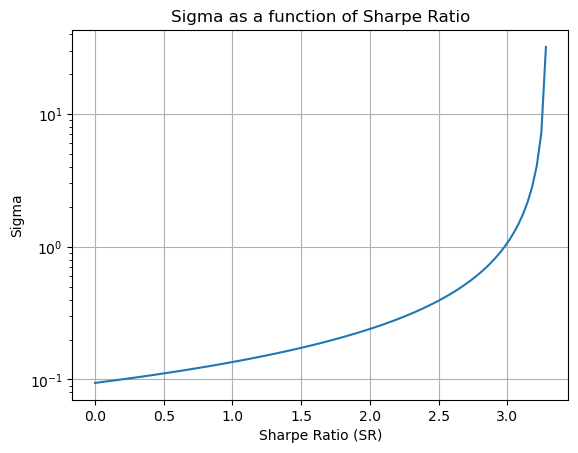

In [ ]:

sr_values = np.linspace(0, 3.28, 100)
sigma_values = [calculate_sigma(L, h, p, sr, rf) for sr in sr_values]

plt.plot(sr_values, sigma_values)
plt.yscale('log')
plt.xlabel('Sharpe Ratio (SR)')
plt.ylabel('Sigma')
plt.title('Sigma as a function of Sharpe Ratio')
plt.grid(True)
plt.show()

* Once you Sharpe Ratio is above 3 (as rare as snow in the summer), risk is unlikely to be the limiting factor
* In this scenario you are likely tp  hit at capacity constraints for your trade since your wealth will be growing so wildly fast
    * For SR=3, your wealth grows at $w\sigma*\frac{\mu}{\sigma}=1*3=300\%$ per year!
  